In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.kernel_approximation import RBFSampler

import time

In [2]:
! ls ../datasets/export/fashion_mnist/numpy/

test_data_fashion_mnist.npy	train_data_fashion_mnist.npy
test_targets_fashion_mnist.npy	train_targets_fashion_mnist.npy


## Loading the data

In [2]:
train_data = np.load('../datasets/export/fashion_mnist/numpy/train_data_fashion_mnist.npy')
test_data = np.load('../datasets/export/fashion_mnist/numpy/test_data_fashion_mnist.npy')
train_labels = np.load('../datasets/export/fashion_mnist/numpy/train_targets_fashion_mnist.npy')
test_labels = np.load('../datasets/export/fashion_mnist/numpy/test_targets_fashion_mnist.npy')

D = train_data[0].reshape(-1).shape[0]

# Flatten the images
train_data = train_data.reshape(-1, D)
test_data = test_data.reshape(-1, D)

# Convert one-hot to integers
train_labels = np.argmax(train_labels, axis=1)
test_labels = np.argmax(test_labels, axis=1)

## Quick inspection

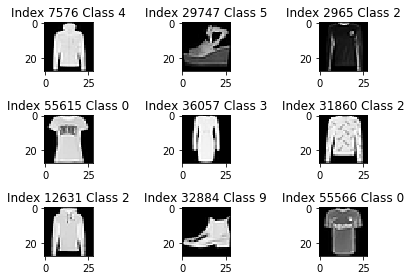

In [106]:
# random check with nine training examples
indices = list(np.random.randint(len(train_data),size=9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_data[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], train_labels[indices[i]]))
    plt.tight_layout()

In [ ]:
# Labels:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

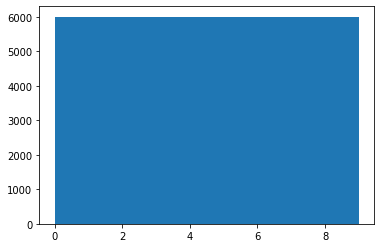

In [107]:
# Train label distribution
plt.hist(train_labels)
plt.show()

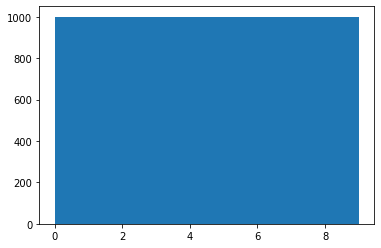

In [108]:
# Test label distribution
plt.hist(test_labels)
plt.show()

## Preprocessing

In [3]:
def threshold_binarize(data, threshold):
    data_bin = np.where(data>threshold, 1, 0)
    return data_bin

In [4]:
# fashion mnist has values between 0 and 255
threshold = 10

train_data_bin = threshold_binarize(train_data, threshold)
test_data_bin = threshold_binarize(test_data, threshold)

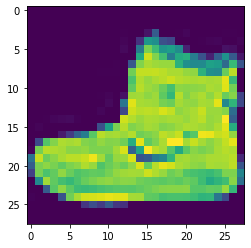

In [120]:
# Original
plt.imshow(train_data.reshape(-1,28,28)[0])

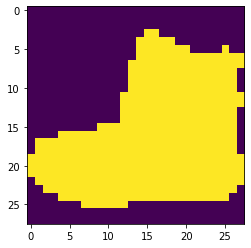

In [121]:
# Threshold binarized
plt.imshow(train_data_bin.reshape(-1,28,28)[0])

## Ridge Classifier

In [129]:
# Without binarization

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_data, train_labels)
clf.score(test_data, test_labels)

/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.69134e-09): result may not be accurate.
  overwrite_a=True).T


0.8113

In [124]:
threshold_values = [i * 10 for i in range(26)]

for t in threshold_values:
    clf = RidgeClassifier(alpha=1.0)
    train_data_bin = threshold_binarize(train_data, t)
    test_data_bin = threshold_binarize(test_data, t)
    clf.fit(train_data_bin, train_labels)
    train_score = clf.score(train_data_bin, train_labels)
    test_score = clf.score(test_data_bin, test_labels)
    
    print('Treshold:', t, 'Train-Score:', train_score, 'Test-Score:', test_score)

Treshold: 0 Train-Score: 0.82665 Test-Score: 0.812
Treshold: 10 Train-Score: 0.8341166666666666 Test-Score: 0.8168
Treshold: 20 Train-Score: 0.8316 Test-Score: 0.8168
Treshold: 30 Train-Score: 0.8291333333333334 Test-Score: 0.8161
Treshold: 40 Train-Score: 0.82685 Test-Score: 0.8095
Treshold: 50 Train-Score: 0.824 Test-Score: 0.8052
Treshold: 60 Train-Score: 0.81935 Test-Score: 0.8004
Treshold: 70 Train-Score: 0.81515 Test-Score: 0.7975
Treshold: 80 Train-Score: 0.8104833333333333 Test-Score: 0.7888
Treshold: 90 Train-Score: 0.8049833333333334 Test-Score: 0.7862
Treshold: 100 Train-Score: 0.7998666666666666 Test-Score: 0.7774
Treshold: 110 Train-Score: 0.7909666666666667 Test-Score: 0.7709
Treshold: 120 Train-Score: 0.7832 Test-Score: 0.7631
Treshold: 130 Train-Score: 0.7743666666666666 Test-Score: 0.7564
Treshold: 140 Train-Score: 0.7637 Test-Score: 0.7432
Treshold: 150 Train-Score: 0.75075 Test-Score: 0.7327
Treshold: 160 Train-Score: 0.73555 Test-Score: 0.7203
Treshold: 170 Train-Sc

<div class="alert alert-block alert-info">
Interestingly, low thresholds lead to the highest scores. I.e. keeping the rough shape leads to better recognition than preserving some of the texture (higher threshold). Hence, we will stick to $t=10$.
    
In general, binarization does not degrade performance on this dataset.
</div>

In [5]:
train_data_bin = threshold_binarize(train_data, 10)
test_data_bin = threshold_binarize(test_data, 10)
all_data = np.vstack([train_data_bin, test_data_bin])

In [13]:
def synthetic_opu(data, output_dim, std_dev):
    A = np.random.normal(loc=0.0, scale=std_dev, size=(data.shape[1], output_dim))
    B = np.random.normal(loc=0.0, scale=std_dev, size=(data.shape[1], output_dim))
    
    return (data @ A)**2 + (data @ B)**2

In [ ]:
data_proj = synthetic_opu(all_data, output_dim=int(1e4), std_dev=1.0)

In [21]:
def rbf_fourier_features(data, output_dim, gamma='auto'):
    if gamma == 'auto':
        # same initialization as for the svm in sklearn
        n_features = data.shape[1]
        gamma = 1. / (n_features * data.var())
    sampler = RBFSampler(gamma=gamma, n_components=output_dim, random_state=1)
    return sampler.fit_transform(data)

In [22]:
data_proj = rbf_fourier_features(all_data, output_dim=int(1e4))

In [23]:
data_proj.shape

(70000, 10000)

In [24]:
train_proj = data_proj[:len(train_data_bin)]
test_proj = data_proj[len(train_data_bin):]

In [25]:
# RBF: dim=10K, gamma='auto'
clf = RidgeClassifier(alpha=1.0)
clf.fit(train_proj, train_labels)
clf.score(test_proj, test_labels)

0.8781

In [9]:
# OPU: dim=10K, std_dev=1.0
clf = RidgeClassifier(alpha=1.0)
clf.fit(train_proj, train_labels)
clf.score(test_proj, test_labels)

0.8783

In [ ]:
# TODO: test higher dimensions here!

## Manual Ridge Classifier through Kernel Ridge Regression

Allows for custom kernels!

In [6]:
from sklearn.preprocessing import LabelBinarizer

In [7]:
# like one-hot encoding with 0 corresponding to -1
label_binarizer = LabelBinarizer(pos_label=1, neg_label=-1)
train_labels_bin = label_binarizer.fit_transform(train_labels)
test_labels_bin = label_binarizer.fit_transform(test_labels)

In [12]:
# Kernel ridge lets memory explode!
# Storing an NxN matrix should require:
# N^2 × 32bits ÷ 8bits ÷ 1024^3 (GB), 13.411 (26.8221) GB if we use float32 (64)
# Should be enough!
# See https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/kernel_ridge.py#L16
# for more information...
# https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/linear_model/ridge.py#L586
# describes the kernel inversion method
# it is exactly the same as the one from the 2015 paper

clf = KernelRidge(alpha=1.0, kernel='linear')
clf.fit(train_data_bin, train_labels_bin) 

MemoryError: 

## SVM

In [5]:
# RBF True Kernel (10 minutes)

since = time.time()

clf = SVC(C=1.0, kernel='rbf', degree=3)
clf.fit(train_data_bin, train_labels)
score = clf.score(test_data_bin, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Score: 0.8598
Time: 746.04407787323
